In [1]:
import sys
import os
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Adiciona o caminho para a pasta 'src' ao sys.path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', 'src')))

from data_analysis import *
from data_preprocessing import *
from visualization import *

In [2]:
# Caminho para o banco de dados SQLite
db_path = r"C:\GitHub\Projeto-Power-BI-Data-Analysis\data\processed\stg\stg_data.db"

# Conecta ao banco de dados
conn = sqlite3.connect(db_path)
cursor = conn.cursor()


In [3]:
df_olist_customers = pd.read_sql_query(f"SELECT * FROM  stg_olist_customers", conn)
# Fechar a conexão
conn.close()
df_olist_customers.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [ ]:
analisar_categorias(df_olist_customers)


In [ ]:
contar_valores_nulos(df_olist_customers)

In [ ]:
verificar_tipos_dados(df_olist_customers)

In [ ]:
encontrar_colunas_constantes(df_olist_customers)

In [ ]:
identificar_outliers(df_olist_customers, "customer_zip_code_prefix", metodo="desvio_padrao", fator=2.7)


In [ ]:
print(df_olist_customers.select_dtypes(include=["number"]).head())


*Análise da Matriz de Correlação*

A matriz mostra a correlação entre as variáveis do dataset. Os valores variam de -1 a 1, onde:

- 1.00 indica correlação perfeita positiva. 
- 0.00 indica ausência de correlação. 
- -1.00 indica correlação perfeita negativa. 

customer_zip_code_prefix tem uma influência moderada sobre customer_city e customer_state, o que faz sentido geograficamente.
customer_id e customer_unique_id não possuem relevância para a análise de correlação. Se o objetivo for prever ou entender padrões, essas colunas podem ser descartadas.
A correlação entre customer_state e customer_city é fraca (~0.26), indicando que há variação significativa dentro dos estados.

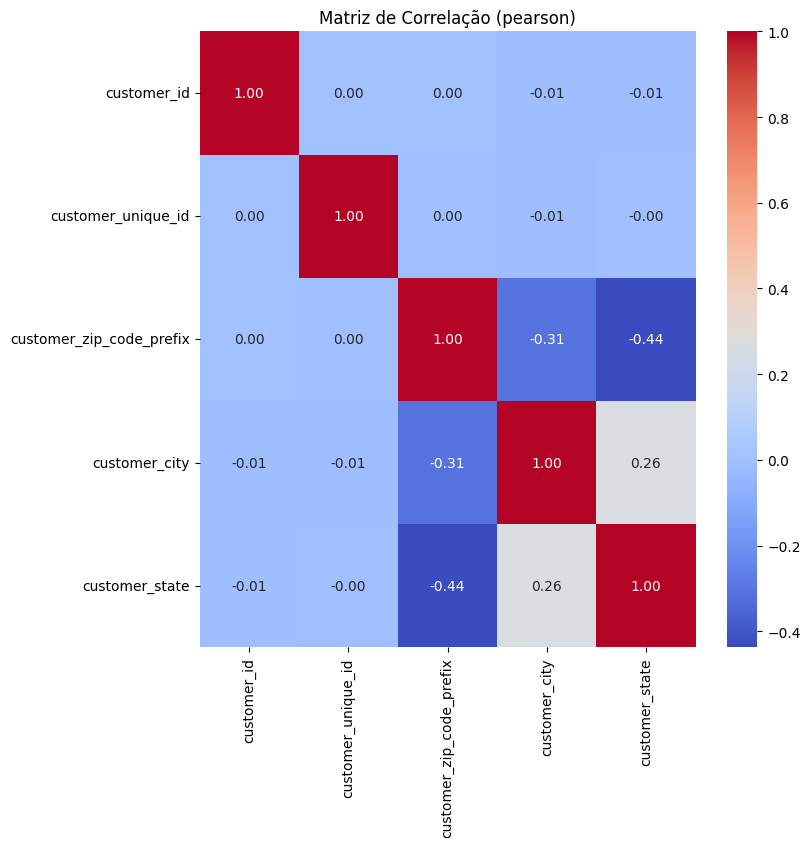

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
customer_id,1.000000,0.002560,0.002042,-0.005715,-0.005860
customer_unique_id,0.002560,1.000000,0.000202,-0.006406,-0.002416
customer_zip_code_prefix,0.002042,0.000202,1.000000,-0.308916,-0.437663
customer_city,-0.005715,-0.006406,-0.308916,1.000000,0.262024
customer_state,-0.005860,-0.002416,-0.437663,0.262024,1.000000


In [6]:
plot_matriz_correlacao_Encoding(df_olist_customers, method="pearson")


In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_olist_customers["customer_city_encoded"] = le.fit_transform(df_olist_customers["customer_city"])


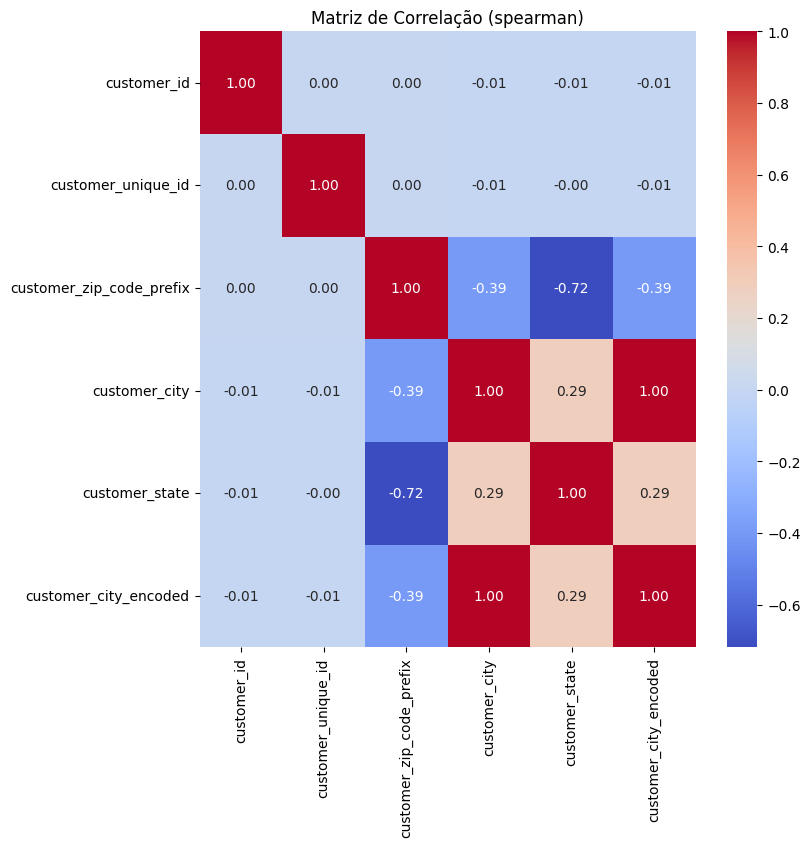

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_city_encoded
customer_id,1.000000,0.002560,0.004269,-0.005063,-0.005443,-0.005063
customer_unique_id,0.002560,1.000000,0.001179,-0.007046,-0.001999,-0.007046
customer_zip_code_prefix,0.004269,0.001179,1.000000,-0.390290,-0.719092,-0.390290
customer_city,-0.005063,-0.007046,-0.390290,1.000000,0.287407,1.000000
customer_state,-0.005443,-0.001999,-0.719092,0.287407,1.000000,0.287407
customer_city_encoded,-0.005063,-0.007046,-0.390290,1.000000,0.287407,1.000000


In [12]:
plot_matriz_correlacao_Encoding(df_olist_customers, method="spearman")
